In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as trans
import pandas as pd
import xarray as xr
from osgeo import gdal
from scipy.io import loadmat
import rasterio
from rasterio.windows import Window,from_bounds
import rasterio.warp
import rasterio.mask
from rasterio.merge import merge
import geopandas as gpd
from scipy.interpolate import interp2d, NearestNDInterpolator, RegularGridInterpolator


In [2]:
def xyz_geotiff(img):
    band = img.GetRasterBand(1)
    z = np.flipud(band.ReadAsArray()).T
    width = img.RasterXSize
    height = img.RasterYSize
    gt = img.GetGeoTransform()
    minx = gt[0]
    miny = gt[3] + width*gt[4] + height*gt[5]
    maxx = gt[0] + width*gt[1] + height*gt[2]
    maxy = gt[3]
    lon = np.linspace(minx,maxx,width)
    lat = np.linspace(miny,maxy,height)
    return lon,lat,z

In [3]:
def era5_pad_window(file, lon, lat, padlon=0.0,padlat=0.0):
    minx = lon-padlon
    maxx = lon+padlon
    miny = lat-padlat
    maxy = lat+padlat
        
    with rasterio.open(file) as src:
            wnd_row_off_min, wnd_col_off_min = src.index(minx, maxy)
            wnd_row_off_max, wnd_col_off_max = src.index(maxx, miny)
            window = Window(wnd_col_off_min,wnd_row_off_min,wnd_col_off_max - wnd_col_off_min,wnd_row_off_max - wnd_row_off_min)
            transform = src.window_transform(window)
            img = src.read(1,window=window)
            meta = src.meta.copy()
            meta.update({"height": window.height,"width": window.width,"transform": transform})
            rows_mask = np.arange(0, img.shape[0])
            cols_mask = np.arange(0, img.shape[1])
            _, lats_mask = np.array(rasterio.transform.xy(transform, rows_mask, [0]))
            lons_mask, _ = np.array(rasterio.transform.xy(transform, [0], cols_mask))

            return img, lats_mask, lons_mask

In [4]:
def transect2dxyz(p0,p1,x,y,z):
    # p0 is the point the line starts on
    # finishes on p1
    # step along line is equal to x spacing
    tempinterpolator = RegularGridInterpolator((x,y),z)
    linelength = ((p1[0]-p0[0])**2+(p1[1]-p0[1])**2)**0.5
    spoints = np.arange(0,linelength,np.diff(x)[0])
    xpoints = np.cos(np.arctan2(p1[1]-p0[1],p1[0]-p0[0]))*spoints+p0[0]
    ypoints = np.sin(np.arctan2(p1[1]-p0[1],p1[0]-p0[0]))*spoints+p0[1]
    zpoints = tempinterpolator((xpoints,ypoints))
    return spoints,xpoints,ypoints,zpoints

In [5]:
img, lats, lons = era5_pad_window('Mars_MOLA_200m.tif',-170.649, 8.387, 0.5,0.5 )
small_window=img

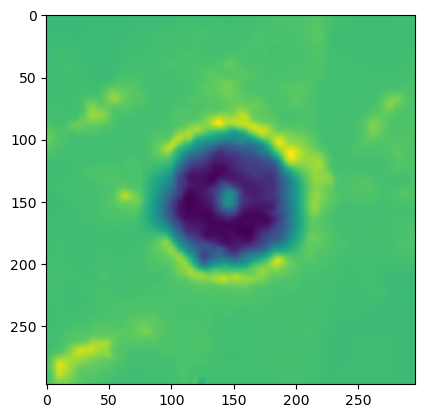

In [6]:
# img, lats, lons = era5_pad_window('Mars_MOLA_200m.tif',-170.649, 8.387, 0.5,0.5 )
# #img = np.flipud(img)
plt.imshow(small_window)

In [7]:
img.save("One_Crater.tif")

AttributeError: 'numpy.ndarray' object has no attribute 'save'

In [ ]:

#data_geotiff = gdal.Open(img)
lon_geotiff,lat_geotiff,z_geotiff = xyz_geotiff(small_window)

AttributeError: 'numpy.ndarray' object has no attribute 'GetRasterBand'

In [ ]:
p0 = [50.1,18.66]
p1 = [50.15,18.84]
spoints,lonpoints,latpoints,zpoints = transect2dxyz(p0,p1,
                                                    lon_geotiff,lat_geotiff,z_geotiff)

fig = plt.gcf()

ax1 = plt.subplot(121)

plt.pcolormesh(lon_geotiff,lat_geotiff,z_geotiff.T,cmap='binary_r')
plt.colorbar(label='elevation (m)')
plt.axis('square')

ax2 = plt.subplot(122)

ax1.plot(lonpoints,latpoints,c='y')
ax2.plot(spoints,zpoints,c='y')
    
ax1.set_xlabel('longitude ($\\degree$)')
ax1.set_ylabel('latitude ($\\degree$)')
ax2.set_xlabel('transect ($\\degree$)')
ax2.set_ylabel('elevation (m)')
ax2.set_xlim(spoints[0],spoints[-1])

fig.set_size_inches(12,4)

ValueError: There are 296 points and 297 values in dimension 0